# Predição de ações Itausa (ITSA4)

## Historia ITAUSA

Itausa Investimentos Itau SA é uma empresa sediada no Brasil e tem como atividade principal o setor bancário. As atividades da Companhia estão divididas em dois segmentos de negócios: Financeiro e Industrial. 

A divisão Financeiral concentra-se na gestão do Itau Unibanco Holding SA, uma instituição bancária que oferece produtos e serviços financeiros, como empréstimos, cartões de crédito, contas correntes, apólices de seguros, ferramentas de investimento, corretagem de valores mobiliários, consultoria de tesouraria e investimentos para clientes individuais e empresas. 

A divisão Industrial é responsável pela operação da Itautec SA, que fabrica equipamentos de automação comercial e bancária, além de prestar serviços de tecnologia da informação (TI); Duratex SA, que produz painéis de madeira, louças sanitárias e metais sanitários, e Alpargatas, que produz calçados sob as marcas Juntas, Havaianas e Dupe, entre outros.

## Funções


In [1]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

## Leitura de dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('darkgrid')

In [223]:
itausa = pd.read_csv('dataset_itsa4.csv',';')

In [224]:
itausa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Covid
0,04/01/2016,4.22,4.35,4.37,4.22,27970000.0,-0.04,0
1,05/01/2016,4.29,4.28,4.31,4.23,15310000.0,0.02,0
2,06/01/2016,4.33,4.23,4.41,4.21,33250000.0,0.01,0
3,07/01/2016,4.27,4.25,4.31,4.21,22800000.0,-0.01,0
4,08/01/2016,4.27,4.31,4.34,4.24,14370000.0,0.00,0


In [225]:
itausa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      1295 non-null   object 
 1   Último    1295 non-null   float64
 2   Abertura  1295 non-null   float64
 3   Máxima    1295 non-null   float64
 4   Mínima    1295 non-null   float64
 5   Vol.      1295 non-null   float64
 6   Var%      1295 non-null   float64
 7   Covid     1295 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 81.1+ KB


### Tratamento de Dados

In [226]:
itausa['Data'] = pd.to_datetime(itausa['Data']).dt.date
itausa['Mes'] = pd.to_datetime(itausa['Data']).dt.month
itausa['Quadrimestre'] = pd.to_datetime(itausa['Data']).dt.quarter
itausa['Dia_da_Semana'] = pd.to_datetime(itausa['Data']).dt.dayofweek

In [227]:
itausa.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Covid,Mes,Quadrimestre,Dia_da_Semana
1290,2021-03-23,10.26,10.41,10.54,10.26,21300000.0,-0.02,1,3,1,1
1291,2021-03-24,10.05,10.30,10.31,10.03,23600000.0,-0.02,1,3,1,2
1292,2021-03-25,10.26,10.02,10.26,9.97,24740000.0,0.02,1,3,1,3
1293,2021-03-26,10.36,10.18,10.38,10.17,21190000.0,0.01,1,3,1,4
1294,2021-03-29,10.32,10.28,10.37,10.17,18090000.0,0.00,1,3,1,0


## Analise Exploratoria

In [228]:
itausa.describe()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Covid,Mes,Quadrimestre,Dia_da_Semana
count,1295.000000,1295.000000,1295.000000,1295.000000,1.295000e+03,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000
mean,9.049568,9.055521,9.164726,8.934834,2.367632e+07,0.000942,0.237066,6.409266,2.470270,2.378378
std,2.301425,2.304101,2.320299,2.278977,1.234517e+07,0.020789,0.425447,3.425638,1.117725,1.733076
min,4.020000,4.020000,4.060000,4.000000,4.130000e+06,-0.110000,0.000000,1.000000,1.000000,0.000000
25%,7.230000,7.240000,7.300000,7.180000,1.554500e+07,-0.010000,0.000000,3.000000,1.000000,1.000000
50%,9.150000,9.160000,9.320000,8.990000,2.078000e+07,0.000000,0.000000,6.000000,2.000000,2.000000
75%,10.850000,10.840000,10.960000,10.685000,2.862500e+07,0.010000,0.000000,9.000000,3.000000,4.000000
max,13.640000,13.490000,13.660000,13.420000,1.169000e+08,0.100000,1.000000,12.000000,4.000000,6.000000


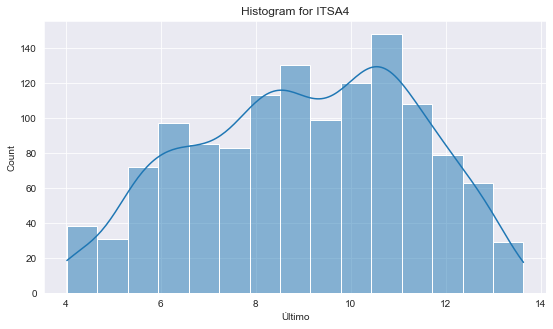

In [229]:
f, ax = plt.subplots(figsize=(9, 5))

sns.histplot(data=itausa, x=itausa['Último'],kde=True)
ax.set(title="Histogram for ITSA4")
plt.show()

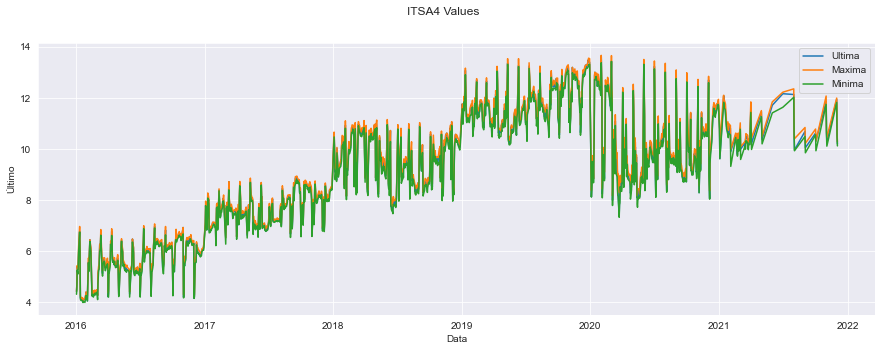

In [230]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="Data", y="Último",label ='Ultima',data=itausa)
sns.lineplot(x="Data", y="Máxima",label ='Maxima',data=itausa)
sns.lineplot(x="Data", y="Mínima",label ='Minima',data=itausa)

plt.suptitle("ITSA4 Values")

plt.show()

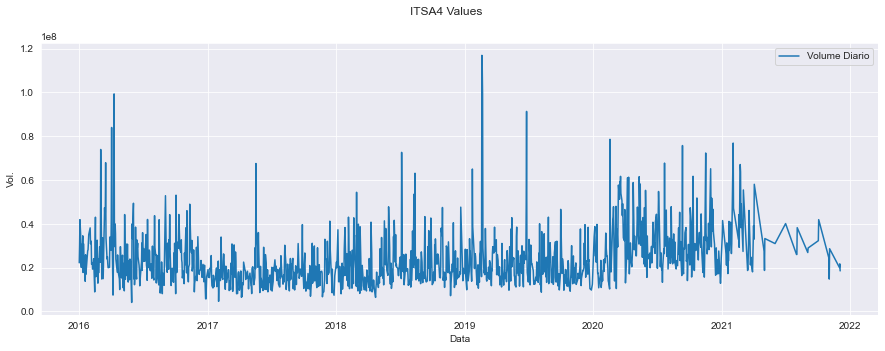

In [231]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="Data", y="Vol.",label ='Volume Diario',data=itausa)

plt.suptitle("ITSA4 Values")

plt.show()

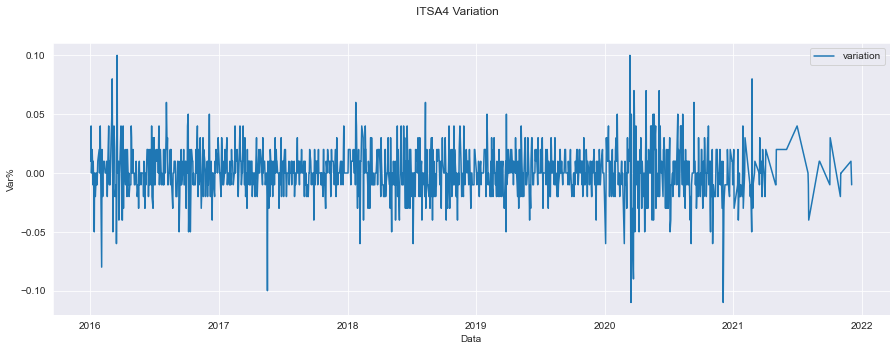

In [232]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="Data", y="Var%",label ='variation',data=itausa)

plt.suptitle("ITSA4 Variation")

plt.show()

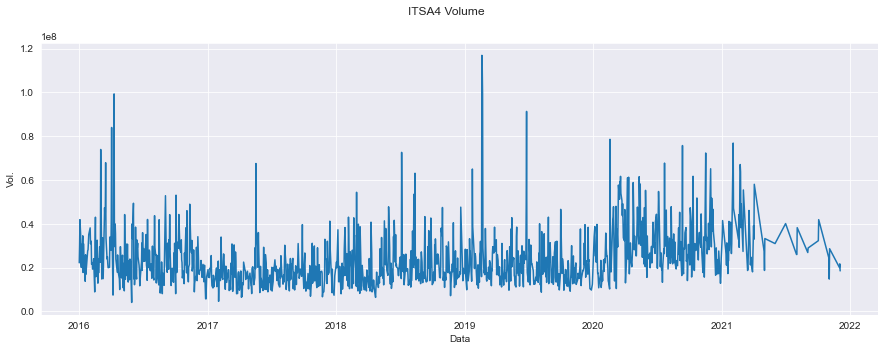

In [156]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x="Data", y="Vol.",data=itausa)

plt.suptitle("ITSA4 Volume")

plt.show()

In [233]:
itausa.describe()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Covid,Mes,Quadrimestre,Dia_da_Semana
count,1295.000000,1295.000000,1295.000000,1295.000000,1.295000e+03,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000
mean,9.049568,9.055521,9.164726,8.934834,2.367632e+07,0.000942,0.237066,6.409266,2.470270,2.378378
std,2.301425,2.304101,2.320299,2.278977,1.234517e+07,0.020789,0.425447,3.425638,1.117725,1.733076
min,4.020000,4.020000,4.060000,4.000000,4.130000e+06,-0.110000,0.000000,1.000000,1.000000,0.000000
25%,7.230000,7.240000,7.300000,7.180000,1.554500e+07,-0.010000,0.000000,3.000000,1.000000,1.000000
50%,9.150000,9.160000,9.320000,8.990000,2.078000e+07,0.000000,0.000000,6.000000,2.000000,2.000000
75%,10.850000,10.840000,10.960000,10.685000,2.862500e+07,0.010000,0.000000,9.000000,3.000000,4.000000
max,13.640000,13.490000,13.660000,13.420000,1.169000e+08,0.100000,1.000000,12.000000,4.000000,6.000000


## Analise de Outlier

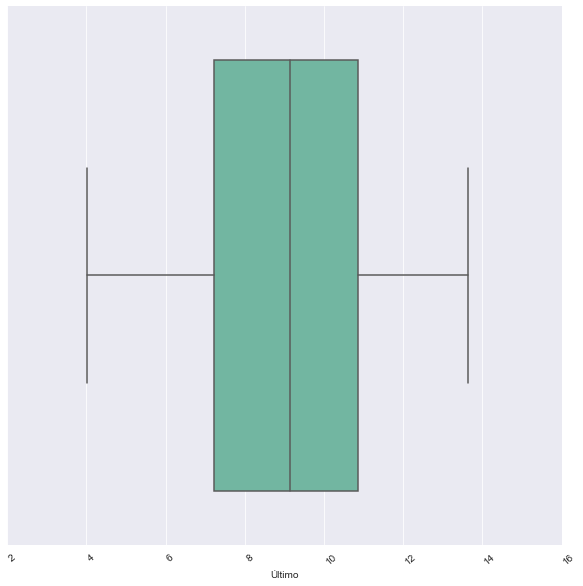

In [158]:
f = sns.catplot(data = itausa,
                    x = 'Último',
                    kind='box',
                    height=8,
                    palette='Set2')
f.set_xticklabels(fontweight='light',fontsize='medium',rotation=40, ha="left")


plt.show()


## Introdução ao Arima

Então, o que exatamente é um modelo ARIMA?

ARIMA, abreviação de 'Auto Regressive Integrated Moving Average' é na verdade uma classe de modelos que 'explica' uma determinada série temporal com base em seus próprios valores anteriores, ou seja, seus próprios atrasos, mais conhecidos como lags, e os erros de previsão defasados, de modo que a equação pode ser usada para prever valores futuros.

Qualquer série temporal "não sazonal" que exibe padrões e não é um ruído branco aleatório pode ser modelada com modelos ARIMA. Um modelo ARIMA é caracterizado por 3 termos definidos por p, d e q onde:

* p é a ordem do termo AR
* q é a ordem do termo MA
* d é o número de diferenciação necessário para tornar a série temporal estacionária

Se uma série temporal tem padrões sazonais, então você precisa adicionar termos sazonais e ela se torna SARIMA, abreviação de ‘Sazonal ARIMA’. Mais sobre isso quando terminarmos o ARIMA.

Então, o que a "ordem do termo AR" significa? Antes de irmos lá, vamos primeiro dar uma olhada no termo 'd'.

A primeira etapa para construir um modelo ARIMA é tornar a série temporal estacionária.

Porque? Porque, o termo ‘Auto Regressivo’ em ARIMA significa que é um modelo de regressão linear que usa seus próprios atrasos como preditores. Os modelos de regressão linear, como você sabe, funciona melhor quando os preditores não estão correlacionados e são independentes uns dos outros.

Então, como fazer uma série estacionária? A abordagem mais comum é diferenciá-lo. Ou seja, subtraia o valor anterior do valor atual. Às vezes, especifica da complexidade da série, mais de uma diferenciação pode ser necessária.

O valor de d, portanto, é o número mínimo de diferenciação necessária para tornar a série estacionária. 
E se a série temporal já para estacionária, então d = 0.

Em seguida, são os termos ‘p’ e ‘q’?

-> P é uma ordem do termo ‘Auto Regressivo’ (AR), refere-se ao número de lags de Y a serem usados como preditores. 

-> Q é uma ordem do termo de 'Média Móvel' (MA) refere-se ao número de erros de previsão dos lags que devem entrar no modelo ARIMA.

O objetivo, portanto, é identificar os valores de p, d e q. Mas como?

Vamos começar encontrando o ‘d’.

O propósito de diferenciá-lo para tornar a série temporal estacionária.

Mas você precisa ter cuidado para não diferenciar demais as séries. Porque, uma série sobrediferenciada pode ainda ser estacionária, o que por sua vez afetará os parâmetros do modelo. Então, como determinar a ordem certa de diferenciação?

A ordem correta de diferenciação é a diferenciação mínima necessária para obter uma série quase estacionária que vagueia em torno de uma média definida e o gráfico ACF chega a zero rapidamente.

Se as autocorrelações forem positivas para muitos números de defasagens (10 ou mais), a série precisa de diferenciação adicional. Por outro lado, se a própria autocorrelação de lag 1 for muito negativa, a série provavelmente está sobrediferenciada.

No caso, você não pode realmente decidir entre duas ordens de diferenciação, então vá com a ordem que dá o menor desvio padrão na série diferenciada. Vamos ver como fazer isso com um exemplo.

Primeiro, vou verificar se a série está estacionária usando o teste Augmented Dickey Fuller (adfuller ()), do pacote statsmodels. Por quê?

Porque, você precisa de diferenciação apenas se a série não for estacionária. Caso contrário, nenhuma diferenciação é necessária, ou seja, d = 0.

A hipótese nula do teste ADF é que a série temporal é não estacionária. Portanto, se o valor p do teste for menor que o nível de significância (0,05), você rejeita a hipótese nula e infere que a série temporal é de fato estacionária.

Portanto, em nosso caso, se P Value> 0,05, prosseguimos com a busca da ordem de diferenciação.

### Analise de Estacionariedade

In [159]:
def adf_test(dataset, log_test = False):
    ds = dataset
    
    if log_test:
        ds = np.log(ds)
        ds.dropna(inplace=True)
    
    alpha = 0.05
    
    result = tsa.adfuller(ds)
    print('Augmented Dickey-Fuller Test')
    print('test statistic: %.10f' % result[0])
    print('p-value: %.10f' % result[1])
    print('critical values')
    
    for key, value in result[4].items():
        print('\t%s: %.10f' % (key, value))
        
    if result[1] < alpha:  #valor de alpha é 0.05 ou 5 %
        print("Rejeitamos a Hipotese Nula")
    else:
        print("Aceitamos a Hipotese Nula")

In [160]:
adf_test(itausa['Último'], True)

Augmented Dickey-Fuller Test
test statistic: -2.8310076023
p-value: 0.0539792394
critical values
	1%: -3.4354571174
	5%: -2.8637953581
	10%: -2.5679707712
Aceitamos a Hipotese Nula


Testamos o conjunto de dados original, bem como o conjunto de dados transformado em log, mas nossa série temporal ainda não é estacionária. Que outras opções temos? Podemos aplicar outras técnicas que transformam os dados, sem alterar suas propriedades:

Diferenciação: que subtraia cada ponto de dados pelo valor de um ponto de tempo específico na série, por exemplo, sempre subtraia pelo valor do próximo período
Decomposição: que isola cada componente da série temporal como tendência, sazonalidade, ciclo, irregularidade
Em nosso caso, vamos tentar diferenciar o conjunto de dados.

Como diferenciar é subtrair, vamos mantê-lo simples e começar diferenciando cada ponto de dados do ponto de dados anterior a ele, ou seja, diferenciar valores consecutivos.

In [18]:
n_diff_dataset = pd.DataFrame(data=np.diff(np.array(itausa['Último'])))
n_diff_dataset.columns = ['Último']

In [19]:
adf_test(n_diff_dataset['Último'],False)

Augmented Dickey-Fuller Test
test statistic: -12.9157560026
p-value: 0.0000000000
critical values
	1%: -3.4354412127
	5%: -2.8637883403
	10%: -2.5679670339
Rejeitamos a Hipotese Nula


Um valor de p menor que 0,05 implica significância e menor que 0,01 implica significância alta. Portanto, p = 0,0000 implica alta significância.

Nossa série temporal é finalmente estacionária, após a diferenciação. Mas se assim não fosse, poderíamos tentar continuar diferenciando as séries temporais.
Diferenciar não significa que você está subtraindo o valor de n períodos anteriores ou subtraindo valores defasados. Essa é a diferença sazonal.

### Analise de AutoCorrelação

**Plotagens de autocorrelação: técnica gráfica para dados estatísticos.**

Um gráfico de autocorrelação mostra as propriedades de um tipo de dados conhecido como série temporal. Uma série temporal refere-se a observações de uma única variável ao longo de um horizonte de tempo especificado. Por exemplo, o preço diário das ações da Microsoft durante o ano de 2013 é uma série temporal.

Os dados transversais referem-se a observações sobre muitas variáveis ​​em um único ponto no tempo. Por exemplo, os preços de fechamento das 30 ações contidas no Dow Jones Industrial Average em 31 de janeiro de 2014 seriam considerados dados transversais.

Um gráfico de autocorrelação é projetado para mostrar se os elementos de uma série temporal são positivamente correlacionados, negativamente correlacionados ou independentes uns dos outros. (O prefixo auto significa "self" - autocorrelação refere-se especificamente à correlação entre os elementos de uma série temporal.)

Um gráfico de autocorrelação mostra o valor da função de autocorrelação (acf) no eixo vertical. Ele pode variar de -1 a 1.

O eixo horizontal de um gráfico de autocorrelação mostra o tamanho do intervalo entre os elementos da série temporal. Por exemplo, a autocorrelação com o lag 2 é a correlação entre os elementos da série temporal e os elementos correspondentes que foram observados dois períodos de tempo antes.

Esta figura mostra um gráfico de autocorrelação para os preços diários das ações da Apple de 1º de janeiro de 2013 a 31 de dezembro de 2013. (referencia) https://www.dummies.com/programming/big-data/data-science/autocorrelation-plots-graphical-technique-for-statistical-data/


O que é lag?

Este valor de k é o intervalo de tempo que está sendo considerado e é chamado de atraso. Uma autocorrelação de atraso 1 (ou seja, k = 1 acima) é a correlação entre os valores que estão separados por um período de tempo. Mais geralmente, uma autocorrelação de defasagem k é a correlação entre valores que estão separados por k períodos de tempo.

Como o valor P é maior do que o nível de significância, vamos diferenciar as séries e ver como o gráfico de autocorrelação se parece.

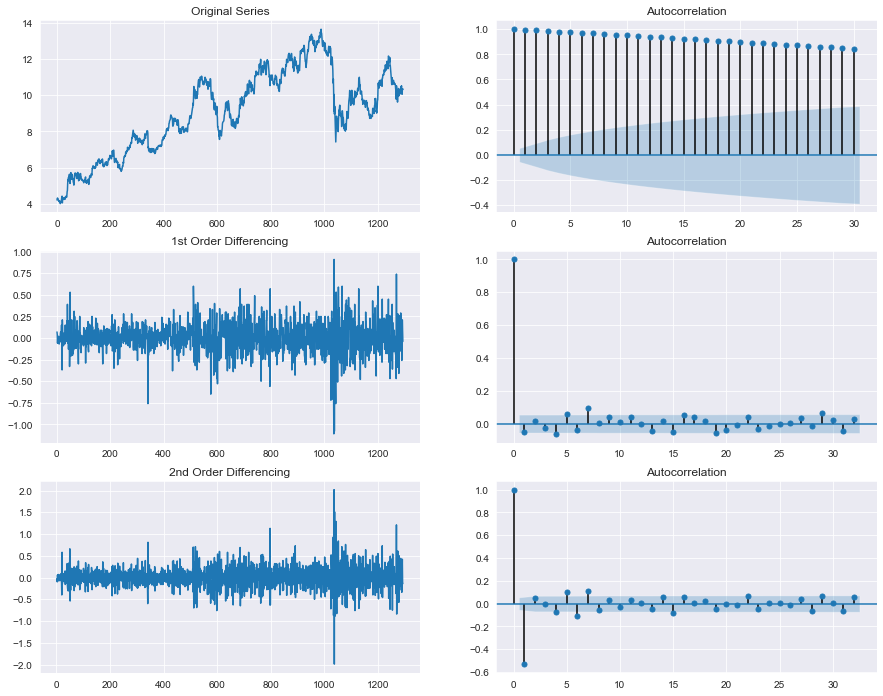

In [234]:
fig, axes = plt.subplots(3, 2,figsize=(15,12))

axes[0, 0].plot(itausa['Último']); axes[0, 0].set_title('Original Series')
plot_acf(itausa['Último'], ax=axes[0, 1],lags=30)

# 1st Differencing
axes[1, 0].plot(itausa['Último'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(itausa['Último'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(itausa['Último'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(itausa['Último'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Sabemos então a serie já estacionaria sem necessidade do primeiro nivel de diferenciação, portanto, d = 0

In [235]:
itausa['Último'].autocorr()

0.9967654330566726

### Correlação 

In [236]:
itausa_corr = itausa.corr()

In [165]:
itausa_corr

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Covid,Mes,Quadrimestre,Dia_da_Semana
Último,1.000000,0.997753,0.998993,0.999019,0.006771,0.005237,0.294477,0.037379,0.044395,0.004036
Abertura,0.997753,1.000000,0.999017,0.998919,0.006150,-0.046302,0.297960,0.038336,0.045488,0.003539
Máxima,0.998993,0.999017,1.000000,0.998778,0.020258,-0.022232,0.305560,0.035034,0.041789,0.003864
Mínima,0.999019,0.998919,0.998778,1.000000,-0.005879,-0.021187,0.290518,0.040619,0.047736,0.003700
Vol.,0.006771,0.006150,0.020258,-0.005879,1.000000,0.015908,0.339901,-0.101798,-0.106903,0.039857
Var%,0.005237,-0.046302,-0.022232,-0.021187,0.015908,1.000000,-0.040124,-0.026362,-0.024735,0.011977
Covid,0.294477,0.297960,0.305560,0.290518,0.339901,-0.040124,1.000000,-0.062381,-0.060736,0.012407
Mes,0.037379,0.038336,0.035034,0.040619,-0.101798,-0.026362,-0.062381,1.000000,0.971165,0.003314
Quadrimestre,0.044395,0.045488,0.041789,0.047736,-0.106903,-0.024735,-0.060736,0.971165,1.000000,0.000625
Dia_da_Semana,0.004036,0.003539,0.003864,0.003700,0.039857,0.011977,0.012407,0.003314,0.000625,1.000000


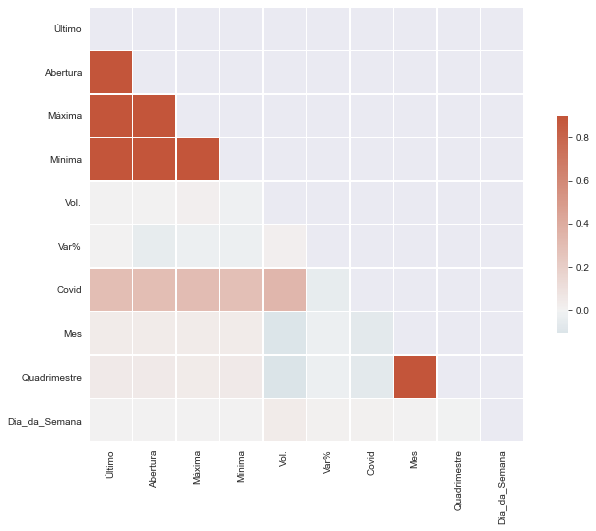

In [25]:
mask = np.triu(np.ones_like(itausa_corr, dtype=bool))

f, ax = plt.subplots(1,figsize=(12,8))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(itausa_corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Analise Decomposição

In [169]:
result = seasonal_decompose(itausa['Último'].values,model='additive',period=60)

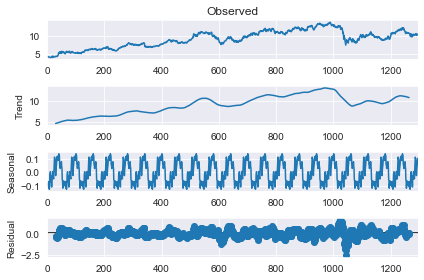

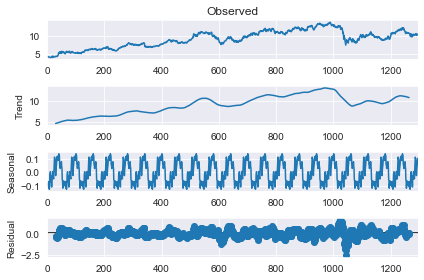

In [170]:
result.plot()

## Como construir o modelo ARIMA

### Treinamento e Teste

In [237]:
#itausa = itausa.set_index(itausa['Data'])
#itausa = itausa.set_index(pd.DatetimeIndex(itausa['Data']).to_period('D'))

itausa = itausa.set_index('Data').asfreq('d')

In [239]:
itausa

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Covid,Mes,Quadrimestre,Dia_da_Semana
Data,,,,,,,,,,
2016-04-01,4.22,4.35,4.37,4.22,27970000.0,-0.04,0.0,4.0,2.0,4.0
2016-04-02,4.34,4.32,4.44,4.21,41780000.0,0.02,0.0,4.0,2.0,5.0
2016-04-03,5.34,5.44,5.58,5.21,83980000.0,0.04,0.0,4.0,2.0,6.0
2016-04-04,5.20,5.32,5.34,5.16,34450000.0,-0.03,0.0,4.0,2.0,0.0
2016-04-05,5.36,5.30,5.38,5.26,28100000.0,0.02,0.0,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-25,10.26,10.02,10.26,9.97,24740000.0,0.02,1.0,3.0,1.0,3.0
2021-03-26,10.36,10.18,10.38,10.17,21190000.0,0.01,1.0,3.0,1.0,4.0
2021-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
itausa = itausa.interpolate(method='linear')

In [242]:
X = itausa.drop(['Último','Abertura','Máxima','Mínima','Mes'], axis=1)
y = itausa['Último'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [243]:
size = int(len(y)* 0.7)
train, test = y[0:size], y[size:len(y)]
history = [x for x in train]
predictions = list()

In [259]:
model = ARIMA(train, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1276
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -713.950
Date:                Tue, 30 Mar 2021   AIC                           1433.901
Time:                        00:57:13   BIC                           1449.355
Sample:                             0   HQIC                          1439.705
                               - 1276                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6341      0.604     14.286      0.000       7.450       9.819
ar.L1          0.9822      0.005    191.732      0.000       0.972       0.992
sigma2         0.1788      0.004     49.305      0.000       0.172       0.186
===================================================================================
Ljung-Box (L1) (Q):                   6.38   Jarque-Bera (JB):              2551.99
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [260]:
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=10.286682, expected=12.586667
predicted=12.488990, expected=12.520000
predicted=12.424320, expected=11.250000
predicted=11.189717, expected=11.130000
predicted=11.073201, expected=11.010000
predicted=10.956685, expected=10.890000
predicted=10.840171, expected=10.550000
predicted=10.509988, expected=11.270000
predicted=11.209311, expected=12.310000
predicted=12.220001, expected=12.320000
predicted=12.229871, expected=12.330000
predicted=12.239743, expected=11.810000
predicted=11.734295, expected=12.390000
predicted=12.298239, expected=12.970000
predicted=12.862600, expected=12.615000
predicted=12.517370, expected=12.260000
predicted=12.172230, expected=12.280000
predicted=12.191817, expected=12.510000
predicted=12.415661, expected=12.490000
predicted=12.396369, expected=12.410000
predicted=12.318706, expected=12.470000
predicted=12.377226, expected=12.530000
predicted=12.435758, expected=12.590000
predicted=12.494302, expected=12.880000
predicted=12.776697, expected=12.970000


predicted=8.730531, expected=8.270000
predicted=8.303624, expected=8.360000
predicted=8.390930, expected=8.450000
predicted=8.478236, expected=8.540000
predicted=8.565540, expected=9.140000
predicted=9.147617, expected=9.120000
predicted=9.128211, expected=8.860000
predicted=8.875986, expected=10.585000
predicted=10.549176, expected=12.310000
predicted=12.222736, expected=11.650000
predicted=11.582207, expected=10.210000
predicted=10.185373, expected=8.770000
predicted=8.789116, expected=9.910000
predicted=9.894384, expected=9.990000
predicted=9.971950, expected=10.070000
predicted=10.049519, expected=9.475000
predicted=9.472686, expected=8.880000
predicted=8.895850, expected=9.690000
predicted=9.681101, expected=8.890000
predicted=8.905574, expected=8.090000
predicted=8.129947, expected=8.390000
predicted=8.420812, expected=8.020000
predicted=8.062037, expected=8.150000
predicted=8.188071, expected=8.280000
predicted=8.314103, expected=8.410000
predicted=8.440131, expected=8.110000
pr

predicted=10.525896, expected=10.593333
predicted=10.551613, expected=10.620000
predicted=10.577330, expected=10.840000
predicted=10.789340, expected=10.690000
predicted=10.644829, expected=10.620000
predicted=10.577404, expected=10.770000
predicted=10.721964, expected=10.676667
predicted=10.632056, expected=10.583333
predicted=10.542146, expected=10.490000
predicted=10.452236, expected=11.595000
predicted=11.517070, expected=12.700000
predicted=12.582545, expected=9.130000
predicted=9.142295, expected=8.595000
predicted=8.627164, expected=8.060000
predicted=8.111521, expected=9.660000
predicted=9.652508, expected=9.820000
predicted=9.806528, expected=9.980000
predicted=9.960552, expected=10.113333
predicted=10.088910, expected=10.246667
predicted=10.217273, expected=10.380000
predicted=10.345642, expected=10.680000
predicted=10.634469, expected=10.980000
predicted=10.923330, expected=11.280000
predicted=11.212237, expected=11.500000
predicted=11.424154, expected=11.660000
predicted=11

In [262]:
res_acc = forecast_accuracy(predictions, y_test)
res_acc

ValueError: operands could not be broadcast together with shapes (1096,) (548,) 

In [ ]:
model_fit.

### Validação

In [247]:
df = pd.DataFrame()
df['Test'] = test
df['Predictions'] = predictions

In [250]:
df = df.loc[0:50]

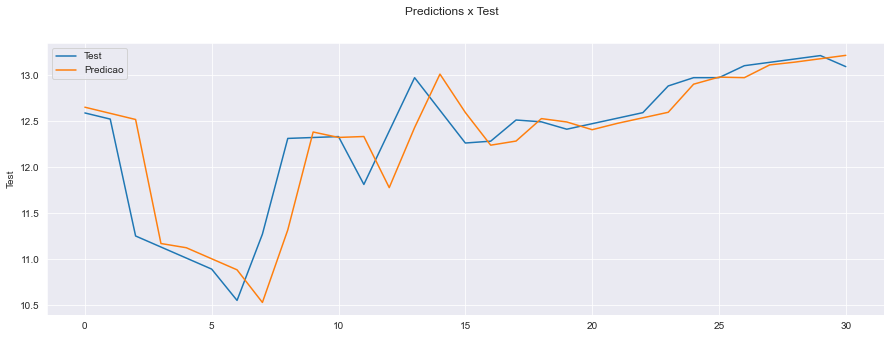

In [251]:
f, axes = plt.subplots(1, figsize=(15,5))

sns.lineplot(x=df.index, y="Test",label ='Test',data=df)
sns.lineplot(x=df.index, y="Predictions",label ='Predicao',data=df)

plt.suptitle("Predictions x Test")

plt.show()

# OLS Model

In [252]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler,OneHotEncoder,RobustScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer

In [253]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [254]:
itausa_y_pred = reg.predict(X_test)

In [255]:
print('Coefficients: \n', reg.coef_)

Coefficients: 
 [-2.03092459e-08  2.41402502e+00  1.53224195e+00 -1.04845004e-01
  1.77829563e-02]


In [256]:
print('Mean squared error: %.2f'% mean_squared_error(y_test, itausa_y_pred))

Mean squared error: 4.25


In [257]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.3f'% r2_score(y_test, itausa_y_pred))

Coefficient of determination: 0.056


In [258]:
res_acc = forecast_accuracy(itausa_y_pred, y_test)
res_acc

{'mape': 0.2007794946094414,
 'me': -0.0373393021177463,
 'mae': 1.7031349301173087,
 'mpe': 0.05163257737305724,
 'rmse': 2.060907713181335}